Uso de EfficientNet-B0 para clasificación de melanoma utilizando la base de datos de Harvard.

In [21]:
#matriz de confusión
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd

In [22]:
import torch
print("¿GPU disponible?:", torch.cuda.is_available())
print("Nombre de la GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No hay GPU")


¿GPU disponible?: True
Nombre de la GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [23]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Definir transformaciones para aumentar los datos
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Tamaño estándar de ResNet50
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalización
])

# Definir directorios
base_dir = r"C:\Users\jakif\CODE\PROYECTO-FINAL\images\PREPROCESSED_DATA_copy"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Directorios para cada clase

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Crear DataLoaders para entrenamiento y prueba
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Clases
print("Clases:", train_dataset.classes)


Clases: ['benign_images', 'malignant_images']


In [24]:
import torch.nn as nn
import torchvision.models as models

# Cargar modelo preentrenado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo:", device)
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)  # Cargar EfficientNet-B0 preentrenado

# Cambiar la última capa para que coincida con el número de clases
num_classes = len(train_dataset.classes)  # Número de clases en el conjunto de datos



# Cambiar la última capa para que coincida con el número de clases
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)  # Cambiar la última capa para que coincida con el número de clases
model = model.to(device)



print(model)


Dispositivo: cuda
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2):

In [25]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Definir función de pérdida y optimizador con weight decay
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Aumenté lr y añadí regularización
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1 )



In [26]:

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=30):
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_recall': [],
        'train_precision': [],
        'train_f1': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_recall': [],
        'val_precision': [],
        'val_f1': [],
        'lr': []  # Para trackear el learning rate
    }
    
    best_val_loss = float('inf')
    early_stopping_patience = 5
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        # Variables para métricas de entrenamiento
        running_loss = 0.0
        correct = 0
        total = 0
        true_positives = 0
        predicted_positives = 0
        total_positives = 0

        # Entrenamiento con mixed precision
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.float32)

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            
            # Añadido label smoothing para mejorar generalización
            loss = criterion(outputs, labels * 0.9 + 0.05)  # Label smoothing
            
            loss.backward()
            # Añadido gradient clipping para evitar exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            with torch.no_grad():
                running_loss += loss.item()
                preds = torch.round(torch.sigmoid(outputs))  # Aplicamos sigmoid aquí para métricas
                
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                true_positives += ((preds == 1) & (labels == 1)).sum().item()
                predicted_positives += (preds == 1).sum().item()
                total_positives += (labels == 1).sum().item()

        # Cálculo de métricas de entrenamiento
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_recall = true_positives / (total_positives + 1e-6)
        train_precision = true_positives / (predicted_positives + 1e-6)
        train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall + 1e-6)
        
        # Guardar métricas de entrenamiento
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['train_recall'].append(train_recall)
        history['train_precision'].append(train_precision)
        history['train_f1'].append(train_f1)

        # Validación
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_true_positives = 0
        val_predicted_positives = 0
        val_total_positives = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device, dtype=torch.float32)

                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.round(torch.sigmoid(outputs))
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                val_true_positives += ((preds == 1) & (labels == 1)).sum().item()
                val_predicted_positives += (preds == 1).sum().item()
                val_total_positives += (labels == 1).sum().item()

        # Cálculo de métricas de validación
        val_loss = val_loss / len(test_loader)
        val_accuracy = 100 * val_correct / val_total
        val_recall = val_true_positives / (val_total_positives + 1e-6)
        val_precision = val_true_positives / (val_predicted_positives + 1e-6)
        val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-6)
        
        # Guardar métricas de validación
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_recall'].append(val_recall)
        history['val_precision'].append(val_precision)
        history['val_f1'].append(val_f1)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Ajustar learning rate
        scheduler.step(val_loss)
        print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")  
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Guardar el mejor modelo
            torch.save(model.state_dict(), 'best_model_EFFICIENTB0.pth')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}!")
                break

        # Imprimir progreso
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Recall: {train_recall:.2f}, Precision: {train_precision:.2f}, F1: {train_f1:.2f}")
        print(f"Val - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, Recall: {val_recall:.2f}, Precision: {val_precision:.2f}, F1: {val_f1:.2f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
        print("-" * 50)

    # Cargar el mejor modelo antes de retornar
    model.load_state_dict(torch.load('best_model_EFFICIENTB0.pth'))
    print("Entrenamiento completado")
    return history

In [27]:
history = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=30)

Current LR: 0.001000
Epoch 1/30
Train - Loss: 0.3930, Accuracy: 87.82%, Recall: 0.40, Precision: 0.61, F1: 0.48
Val - Loss: 0.2954, Accuracy: 89.71%, Recall: 0.43, Precision: 0.85, F1: 0.57
Learning Rate: 1.00e-03
--------------------------------------------------
Current LR: 0.001000
Epoch 2/30
Train - Loss: 0.3547, Accuracy: 90.11%, Recall: 0.49, Precision: 0.72, F1: 0.59
Val - Loss: 0.2509, Accuracy: 90.45%, Recall: 0.69, Precision: 0.70, F1: 0.70
Learning Rate: 1.00e-03
--------------------------------------------------
Current LR: 0.001000
Epoch 3/30
Train - Loss: 0.3394, Accuracy: 91.07%, Recall: 0.56, Precision: 0.75, F1: 0.64
Val - Loss: 0.2350, Accuracy: 91.20%, Recall: 0.53, Precision: 0.86, F1: 0.66
Learning Rate: 1.00e-03
--------------------------------------------------
Current LR: 0.001000
Epoch 4/30
Train - Loss: 0.3314, Accuracy: 91.83%, Recall: 0.61, Precision: 0.77, F1: 0.68
Val - Loss: 0.2623, Accuracy: 90.55%, Recall: 0.49, Precision: 0.86, F1: 0.62
Learning Rate: 

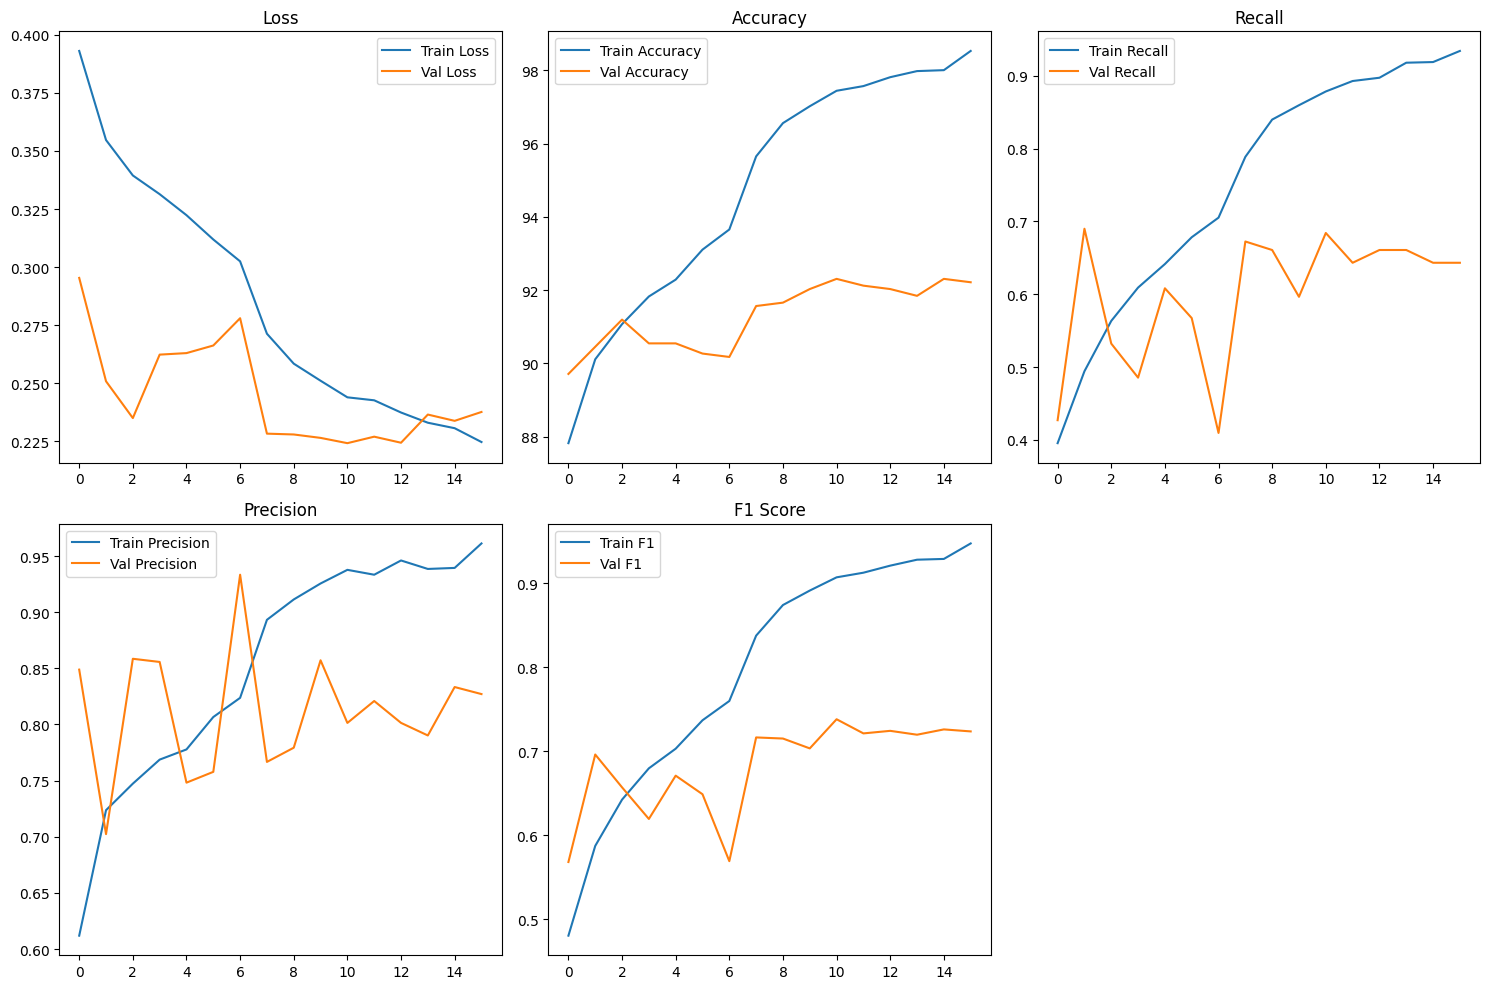

In [28]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(15, 10))
    
    # Gráfico de pérdida
    plt.subplot(2, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    
    # Gráfico de accuracy
    plt.subplot(2, 3, 2)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    # Gráfico de recall
    plt.subplot(2, 3, 3)
    plt.plot(history['train_recall'], label='Train Recall')
    plt.plot(history['val_recall'], label='Val Recall')
    plt.title('Recall')
    plt.legend()
    
    # Gráfico de precision
    plt.subplot(2, 3, 4)
    plt.plot(history['train_precision'], label='Train Precision')
    plt.plot(history['val_precision'], label='Val Precision')
    plt.title('Precision')
    plt.legend()
    
    # Gráfico de F1
    plt.subplot(2, 3, 5)
    plt.plot(history['train_f1'], label='Train F1')
    plt.plot(history['val_f1'], label='Val F1')
    plt.title('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Mostrar gráficos
plot_history(history)

In [29]:

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusión")
    plt.show()

In [30]:

# Evaluar el modelo
def evaluate_model(model, test_loader):
    model.eval()  # Modo evaluación
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.float32)
            outputs = model(images).squeeze()
            preds = torch.round(torch.sigmoid(outputs))  # Convertir logits en 0 o 1

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

                  precision    recall  f1-score   support

   benign_images       0.94      0.97      0.96       908
malignant_images       0.82      0.66      0.73       171

        accuracy                           0.92      1079
       macro avg       0.88      0.82      0.84      1079
    weighted avg       0.92      0.92      0.92      1079



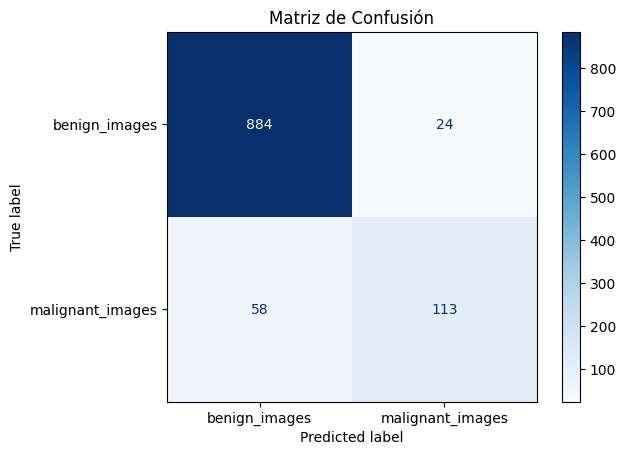

In [31]:

# Evaluar el modelo
all_labels, all_preds = evaluate_model(model, test_loader)
# Imprimir métricas
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))
# Graficar matriz de confusión
plot_confusion_matrix(all_labels, all_preds, classes=train_dataset.classes)

In [32]:
torch.save(model.state_dict(), 'melanoma_model_1_torch_EFFICIENTNETB0_harvard.pth')

In [33]:
import cv2
from PIL import Image

def predict_image(image_path, model):
    model.eval()
    img = Image.open(image_path)
    img = transform(img).unsqueeze(0).to(device)  # Aplicar las mismas transformaciones

    with torch.no_grad():
        output = model(img).squeeze()
        prediction = torch.sigmoid(output).item()
    
    if prediction > 0.5:
        print("🔴 Malignant melanoma")
    else:
        print("🟢 Benign melanoma")

# Prueba con una imagen nueva
predict_image(r'C:\Users\jakif\CODE\PROYECTO-FINAL\images\harvard_dataset\PREPROCESSED_DATA\final\train\benign_images\ISIC_0024306.jpg', model)  # Benigno
predict_image(r'C:\Users\jakif\CODE\PROYECTO-FINAL\images\harvard_dataset\PREPROCESSED_DATA\final\test\malignant_images\ISIC_0034529.jpg', model)  # Maligno

🟢 Benign melanoma
🔴 Malignant melanoma


Predicted class: 1.0


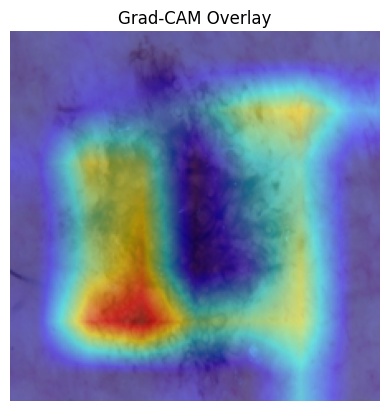

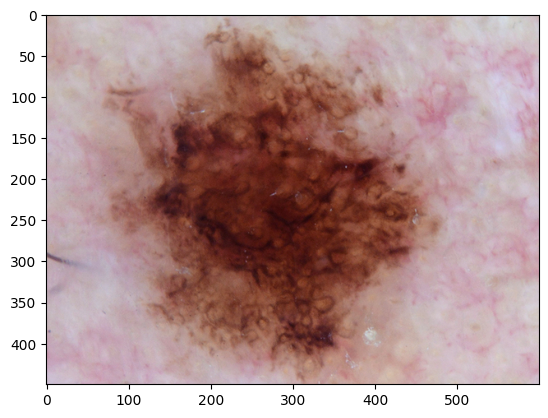

In [34]:
# implementacion gradcam
import torch
import torch.nn.functional as F
import numpy as np
#clase GradCam

class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks for gradients and activations
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x):
        return self.model(x)

    def get_cam(self):
        # Ensure gradients and activations are available
        if self.gradients is None or self.activations is None:
            raise ValueError("Gradients or activations are not available. Perform a backward pass first.")

        # Move gradients and activations to the same device
        device = self.activations.device
        gradients = self.gradients.to(device)

        # Global Average Pooling
        weights = torch.mean(gradients, dim=[0, 2, 3])
        cam = torch.zeros(self.activations.shape[2:], dtype=torch.float32, device=device)

        for i in range(weights.shape[0]):
            cam += weights[i] * self.activations[0, i, :, :]

        cam = F.relu(cam)
        cam = cam - torch.min(cam)
        cam = cam / torch.max(cam)
        return cam.cpu().detach().numpy()
  
# Load the model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 1)  # 1 neuron for binary classification
model.load_state_dict(torch.load('melanoma_model_1_torch_RESNET50_harvard.pth'))
model.eval()
model.to(device)
# Get the target layer
target_layer = model.layer4[2].conv3  # Last convolutional layer
# Create the GradCam object
grad_cam = GradCam(model, target_layer)
# Load and preprocess the image
image_path = r'C:\Users\jakif\CODE\PROYECTO-FINAL\images\harvard_dataset\PREPROCESSED_DATA\final\test\malignant_images\ISIC_0034529.jpg'
image = Image.open(image_path)
image = transform(image).unsqueeze(0).to(device)  # Apply the same transformations
# Forward pass
output = model(image)
# Get the predicted class
predicted_class = torch.round(torch.sigmoid(output)).item()
print("Predicted class:", predicted_class)
# Backward pass
output[0, 0].backward()  # Backpropagate the score for the predicted class
# Get the gradients and activations
gradients = grad_cam.gradients
activations = grad_cam.activations
# Get the CAM
cam = grad_cam.get_cam()
# Resize the CAM to the original image size
original_image = Image.open(image_path)
original_image = original_image.resize((224, 224))
cam = cv2.resize(cam, (original_image.size[0], original_image.size[1]))
# Normalize the CAM
cam = cam - np.min(cam)
cam = cam / np.max(cam)
# Convert the CAM to a heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
# Convert the heatmap to BGR
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
# Convert the original image to numpy array
original_image = np.array(original_image)
# Overlay the heatmap on the original image
overlay = cv2.addWeighted(original_image, 0.5, heatmap, 0.5, 0)
# Display the overlay
plt.imshow(overlay)
plt.axis('off')
plt.title("Grad-CAM Overlay")
plt.show()
image = Image.open(image_path)
plt.imshow(image)
